In [239]:
import numpy as np
import pandas as pd
import pytz

In [240]:
df = pd.read_csv(r'D:\Finplat\data\processed\AAPL_final.csv')
df.head(2)

,Date,Low,Close,Volume,Dividends,RSI_14,MACD,MACD_Signal,ROC_10,S&P500_Return,...,log_returns,open_to_close,daily_volatility,high_to_close,log_valuation,EMA_12_pct,EMA_26_pct,Adaptive_BB_Middle_pct,Daily_Return,Abs_Return
0,2023-03-15 00:00:00-04:00,148.4232,151.4625,77167900,0.0,50.0,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0119,0.0218,1.0017,23.1818,0.0000,0.0000,0.0000,0.0000,0.0000
1,2023-03-16 00:00:00-04:00,150.1260,154.2940,76161100,0.0,50.0,0.2259,0.0452,0.0,0.0176,...,0.0185,0.0243,0.0309,1.0039,23.1872,0.0029,0.0014,0.0187,1.8694,1.8694


In [241]:
df['Date'] = pd.to_datetime(df['Date'],utc=True)
df['Date'] = df['Date'].dt.tz_localize(None)
df = df.set_index('Date')

In [242]:
df.drop(['Daily_Return','Abs_Return'],axis=1,inplace=True)

In [243]:
df.head(2)

,Low,Close,Volume,Dividends,RSI_14,MACD,MACD_Signal,ROC_10,S&P500_Return,S&P500_Correlation,...,TR,Adaptive_ATR_Pct,log_returns,open_to_close,daily_volatility,high_to_close,log_valuation,EMA_12_pct,EMA_26_pct,Adaptive_BB_Middle_pct
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-15 04:00:00,148.4232,151.4625,77167900,0.0,50.0,0.0000,0.0000,0.0,0.0000,0.8031,...,3.2968,2.1766,0.0000,0.0119,0.0218,1.0017,23.1818,0.0000,0.0000,0.0000
2023-03-16 04:00:00,150.1260,154.2940,76161100,0.0,50.0,0.2259,0.0452,0.0,0.0176,0.8031,...,4.7719,2.6147,0.0185,0.0243,0.0309,1.0039,23.1872,0.0029,0.0014,0.0187


In [244]:
leaky_columns = ['Close', 'Low', 'open_to_close', 'daily_volatility', 
                'high_to_close', 'log_valuation', 'EMA_12_pct', 
                'EMA_26_pct', 'Adaptive_BB_Middle_pct']

# Create shifted versions and drop originals
for col in leaky_columns:
    df[f'{col}'] = df[col].shift(1)



In [245]:
df.columns

Index(['Low', 'Close', 'Volume', 'Dividends', 'RSI_14', 'MACD', 'MACD_Signal',
       'ROC_10', 'S&P500_Return', 'S&P500_Correlation', 'Beta_S&P500',
       'Gold_Return', 'Gold_Correlation', 'Oil_Return', 'Oil_Correlation',
       'VIX_Return', 'VIX_Correlation', 'PE_Ratio', 'EPS', 'MA', 'BB_Width',
       'TR', 'Adaptive_ATR_Pct', 'log_returns', 'open_to_close',
       'daily_volatility', 'high_to_close', 'log_valuation', 'EMA_12_pct',
       'EMA_26_pct', 'Adaptive_BB_Middle_pct'],
      dtype='object')

In [246]:
def prepare_features(df, target_col='log_returns', lag_features=None, lag_periods=None):
    """
    Prepare features for LightGBM model including lag features
    """
    # Make a copy to avoid modifying the original
    features_df = df.copy()
    
    # Default lag features if none provided
    if lag_features is None:
        lag_features = ['Close', 'Volume', 'RSI_14', 'MACD', 'ROC_10', 'S&P500_Return']
    
    # Default lag periods if none provided
    if lag_periods is None:
        lag_periods = [1, 3, 5, 10, 20]
    
    # Create lag features
    for feature in lag_features:
        for lag in lag_periods:
            features_df[f'{feature}_lag_{lag}'] = features_df[feature].shift(lag)
    
    # Add time-based features
    # Make sure the index is DatetimeIndex
    if not isinstance(features_df.index, pd.DatetimeIndex):
        print("Converting index to DatetimeIndex")
        features_df.index = pd.to_datetime(features_df.index,utc=True)
        
    # If the index is timezone-aware, convert to timezone-naive
    if features_df.index.tzinfo is not None:
        print("Converting timezone-aware index to timezone-naive")
        features_df.index = features_df.index.tz_localize(None)
    
    # Now add date features
    features_df['day_of_week'] = features_df.index.dayofweek
    features_df['month'] = features_df.index.month
    features_df['quarter'] = features_df.index.quarter
    
    # Drop rows with NaN values (from lag creation)
    features_df = features_df.dropna()
    
    return features_df

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_lightgbm_model_with_cv(df, target_col='log_returns', n_splits=5, plot_results=True):
    """
    Train a LightGBM model with time series cross-validation
    
    Args:
        df: DataFrame with features and target
        target_col: Column to predict
        n_splits: Number of splits for time series cross-validation
        plot_results: Whether to plot cross-validation results
    
    Returns:
        Dictionary with CV results, final model, and metrics
    """
    # Prepare features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.8,
        'subsample': 0.8,
        'n_estimators': 100,
        'verbose': -1
    }
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Initialize arrays to store results
    cv_results = {
        'models': [],
        'train_indices': [],
        'test_indices': [],
        'predictions': [],
        'actual': [],
        'rmse': [],
        'mae': [],
        'r2': []
    }
    
    # Perform time series cross-validation
    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"Fold {i+1}/{n_splits}")
        
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
        
        # Train model
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, valid_data],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(100)
            ]
        )
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        cv_results['models'].append(model)
        cv_results['train_indices'].append(train_idx)
        cv_results['test_indices'].append(test_idx)
        cv_results['predictions'].append(y_pred)
        cv_results['actual'].append(y_test.values)
        cv_results['rmse'].append(rmse)
        cv_results['mae'].append(mae)
        cv_results['r2'].append(r2)
        
        print(f"Fold {i+1} - RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")
    
    # Calculate average metrics
    avg_metrics = {
        'rmse': np.mean(cv_results['rmse']),
        'rmse_std': np.std(cv_results['rmse']),
        'mae': np.mean(cv_results['mae']),
        'mae_std': np.std(cv_results['mae']),
        'r2': np.mean(cv_results['r2']),
        'r2_std': np.std(cv_results['r2'])
    }
    
    print("\nAverage Metrics:")
    print(f"RMSE: {avg_metrics['rmse']:.6f} ± {avg_metrics['rmse_std']:.6f}")
    print(f"MAE: {avg_metrics['mae']:.6f} ± {avg_metrics['mae_std']:.6f}")
    print(f"R²: {avg_metrics['r2']:.6f} ± {avg_metrics['r2_std']:.6f}")
    
    # Train a final model on all data
    full_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(
        params,
        full_train_data,
        num_boost_round=1000
    )
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importance(importance_type='gain')
    }).sort_values(by='Importance', ascending=False)
    
    # Plot results if requested
    if plot_results:
        # Plot metrics across folds
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        
        # R² scores
        axs[0, 0].bar(range(1, n_splits + 1), cv_results['r2'])
        axs[0, 0].set_xlabel('Fold')
        axs[0, 0].set_ylabel('R²')
        axs[0, 0].set_title('R² Scores Across CV Folds')
        axs[0, 0].axhline(avg_metrics['r2'], color='red', linestyle='--')
        axs[0, 0].text(n_splits, avg_metrics['r2'], 
                 f'Mean: {avg_metrics["r2"]:.4f}', va='bottom', ha='right', color='red')
        
        # RMSE
        axs[0, 1].bar(range(1, n_splits + 1), cv_results['rmse'])
        axs[0, 1].set_xlabel('Fold')
        axs[0, 1].set_ylabel('RMSE')
        axs[0, 1].set_title('RMSE Across CV Folds')
        axs[0, 1].axhline(avg_metrics['rmse'], color='red', linestyle='--')
        axs[0, 1].text(n_splits, avg_metrics['rmse'], 
                 f'Mean: {avg_metrics["rmse"]:.4f}', va='bottom', ha='right', color='red')
        
        # Predicted vs Actual for the last fold
        last_fold_idx = len(cv_results['test_indices']) - 1
        test_idx = cv_results['test_indices'][last_fold_idx]
        
        # Predictions vs Actual
        axs[1, 0].scatter(cv_results['actual'][last_fold_idx], 
                     cv_results['predictions'][last_fold_idx], alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(min(cv_results['actual'][last_fold_idx]), 
                    min(cv_results['predictions'][last_fold_idx]))
        max_val = max(max(cv_results['actual'][last_fold_idx]), 
                    max(cv_results['predictions'][last_fold_idx]))
        axs[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--')
        
        axs[1, 0].set_xlabel('Actual')
        axs[1, 0].set_ylabel('Predicted')
        axs[1, 0].set_title(f'Predicted vs Actual (Last Fold, R² = {cv_results["r2"][last_fold_idx]:.4f})')
        
        # Feature importance
        top_n_features = min(20, len(feature_importance))
        top_features = feature_importance.head(top_n_features)
        
        axs[1, 1].barh(np.arange(top_n_features), top_features['Importance'])
        axs[1, 1].set_yticks(np.arange(top_n_features))
        axs[1, 1].set_yticklabels(top_features['Feature'])
        axs[1, 1].set_title('Top Feature Importance')
        axs[1, 1].set_xlabel('Importance (Gain)')
        
        plt.tight_layout()
        plt.show()
        
        # Plot predictions vs actual for the last fold over time
        plt.figure(figsize=(14, 7))
        plt.plot(df.iloc[test_idx].index, cv_results['actual'][last_fold_idx], 
                 label='Actual', marker='o', alpha=0.7)
        plt.plot(df.iloc[test_idx].index, cv_results['predictions'][last_fold_idx], 
                 label='Predicted', marker='x', alpha=0.7)
        plt.title(f'Time Series Prediction (Last Fold, R² = {cv_results["r2"][last_fold_idx]:.4f})')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel(target_col)
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return {
        'cv_results': cv_results,
        'avg_metrics': avg_metrics,
        'final_model': final_model,
        'feature_importance': feature_importance
    }


def train_lightgbm_model(df, target_col='log_returns', test_size=0.2, use_cv=False, n_splits=5):
    """
    Train a LightGBM model for time series prediction
    
    Args:
        df: DataFrame with features and target
        target_col: Column to predict
        test_size: Proportion of data to use for testing (used only if use_cv=False)
        use_cv: Whether to use time series cross-validation
        n_splits: Number of splits for cross-validation (used only if use_cv=True)
    
    Returns:
        If use_cv=False: (model, X_train, y_train, X_test, y_test, y_pred, metrics)
        If use_cv=True: Dictionary with CV results, final model, and metrics
    """
    if use_cv:
        return train_lightgbm_model_with_cv(df, target_col, n_splits)
    else:
        # Original function logic
        # Prepare features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        # Time-based split (not random)
        split_idx = int(len(df) * (1 - test_size))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        # LightGBM parameters
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'feature_fraction': 0.8,
            'subsample': 0.8,
            'n_estimators': 100,
            'early_stopping_rounds': 20,
            'verbose': -1
        }
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
        
        # Train model
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, valid_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
        )
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate model
        metrics = {
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred)
        }
        
        return model, X_train, y_train, X_test, y_test, y_pred, metrics

Fold 1/5
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.00569018	valid_1's rmse: 0.00976476
Did not meet early stopping. Best iteration is:
[79]	training's rmse: 0.00624822	valid_1's rmse: 0.00975237
Fold 1 - RMSE: 0.009752, MAE: 0.007694, R²: 0.356497
Fold 2/5
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.00432691	valid_1's rmse: 0.0109571
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.00432691	valid_1's rmse: 0.0109571
Fold 2 - RMSE: 0.010957, MAE: 0.008021, R²: 0.212713
Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's rmse: 0.00603816	valid_1's rmse: 0.0147076
Fold 3 - RMSE: 0.014708, MAE: 0.009722, R²: 0.236389
Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's rmse: 0.00902909	valid_1's rmse: 0.01082
Fold 4 - RMSE: 0.010820, MAE: 0.007900

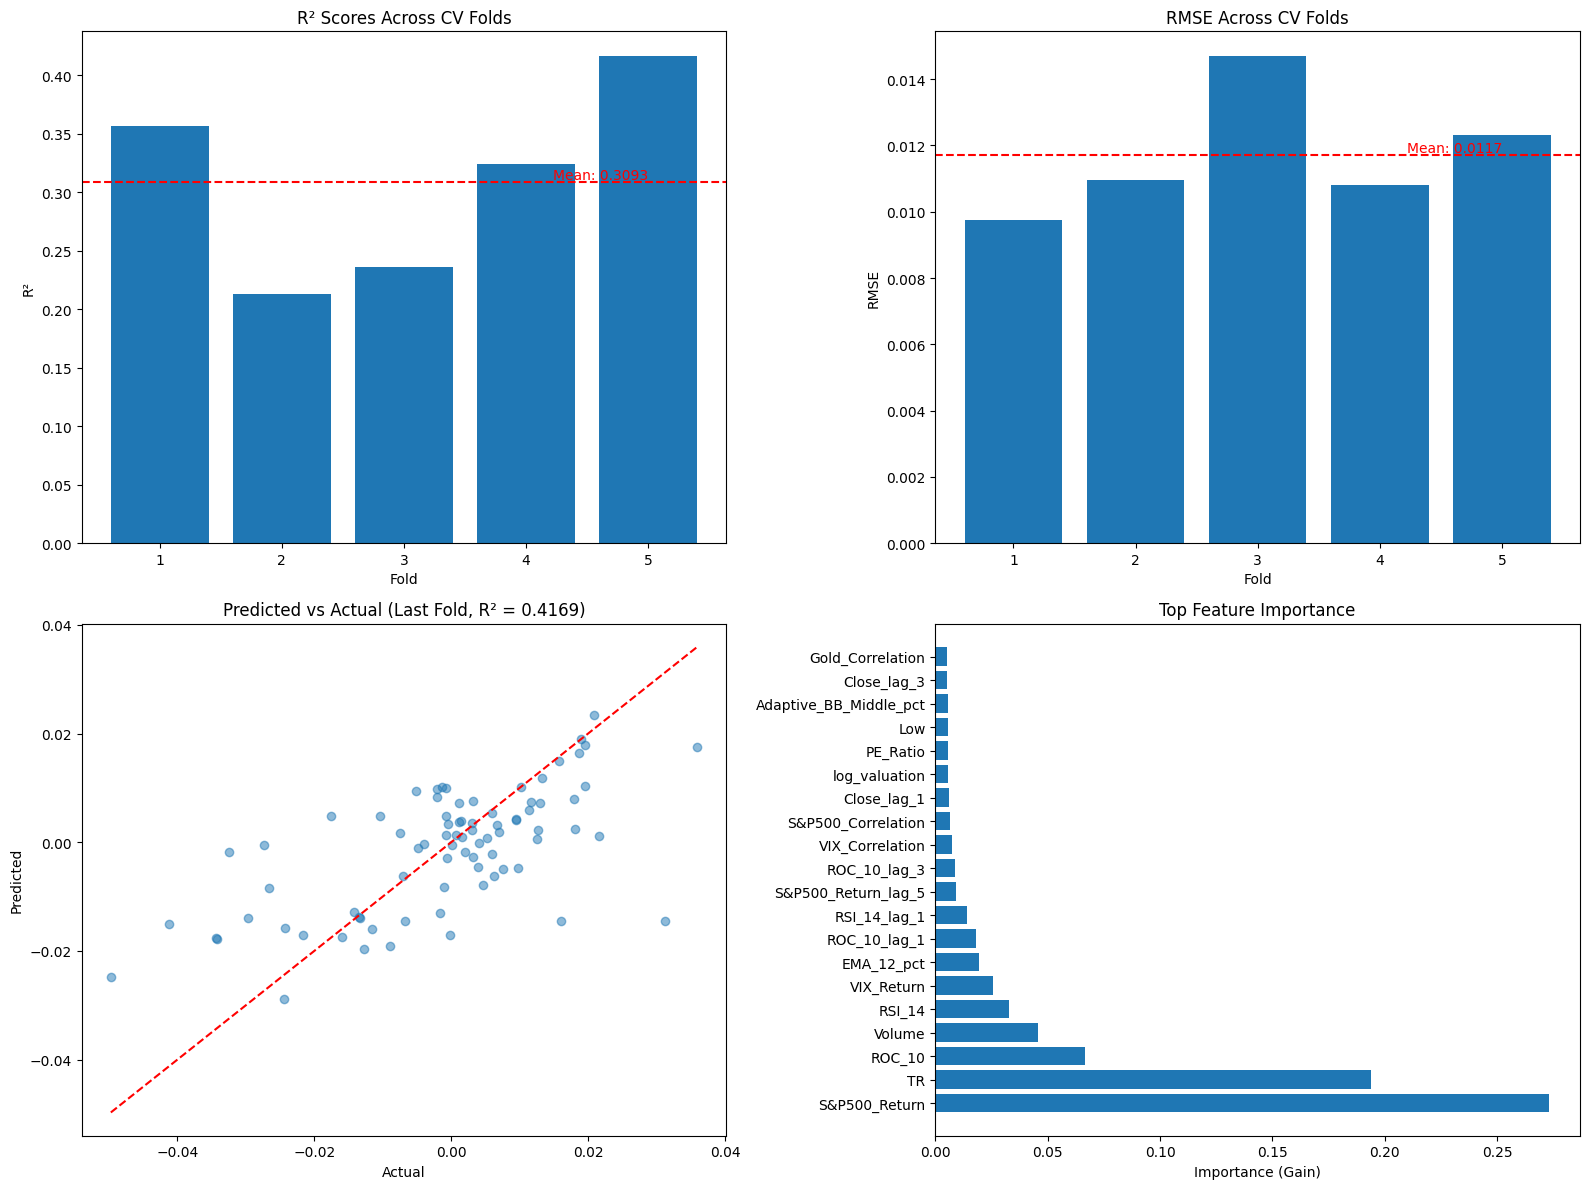

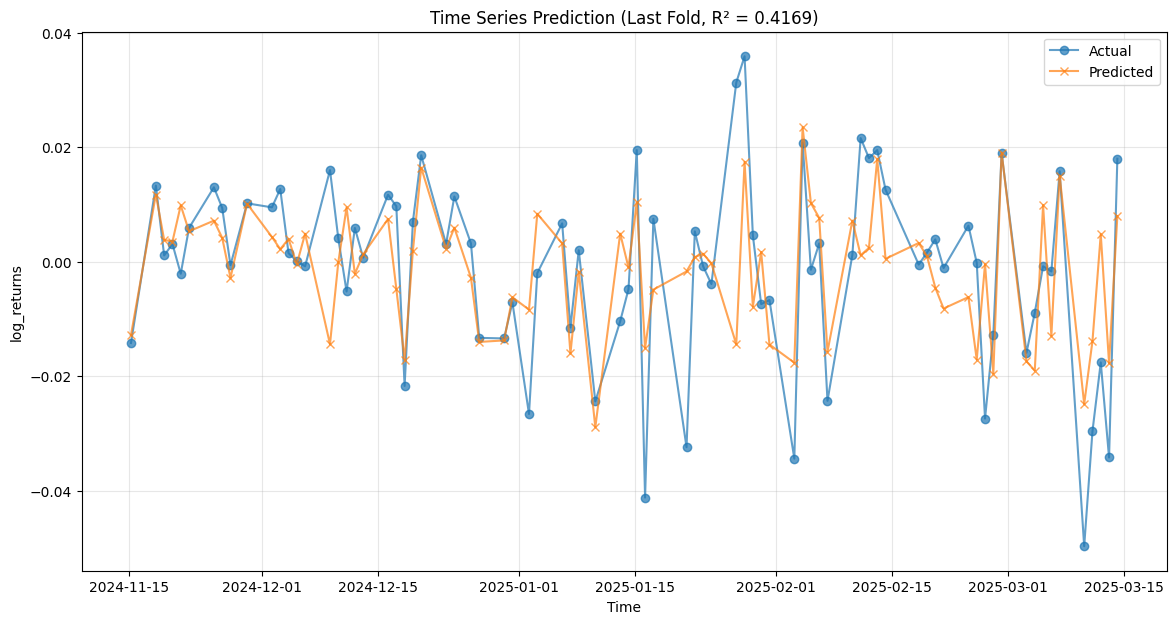

ValueError: not enough values to unpack (expected 7, got 4)

In [249]:



# Prepare features
features_df = prepare_features(df, target_col='log_returns')

# Train model
model, X_train, y_train, X_test, y_test, y_pred, metrics = train_lightgbm_model(features_df,use_cv=True)

# Print metrics
print(f"RMSE: {metrics['rmse']:.6f}")
print(f"MAE: {metrics['mae']:.6f}")
print(f"R2 Score: {metrics['r2']:.6f}")

# Plot feature importance
lgb.plot_importance(model, max_num_features=20, figsize=(10, 8))
plt.title('Feature Importance')
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Daily Returns')
plt.legend()
plt.show()

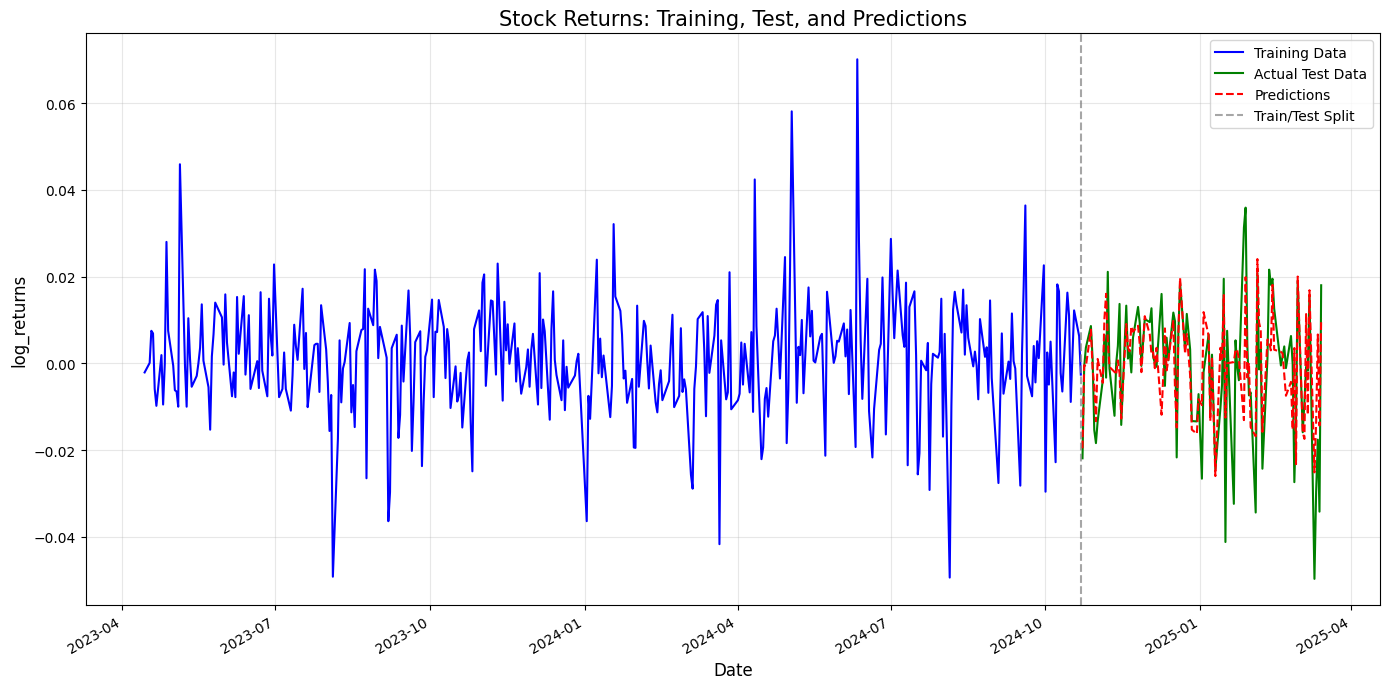

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you already have your model trained and predictions made:
# - y_train: training target values
# - y_test: test target values
# - y_pred: predicted values on test set
# - X_train: training feature set
# - X_test: test feature set

# Create a figure with good size
plt.figure(figsize=(14, 7))

# Get the dates for both training and test sets
train_dates = X_train.index
test_dates = X_test.index

# First plot the training data
plt.plot(train_dates, y_train.values, color='blue', label='Training Data')

# Now plot the test data
plt.plot(test_dates, y_test.values, color='green', label='Actual Test Data')

# And the predictions
plt.plot(test_dates, y_pred, color='red', linestyle='--', label='Predictions')

# Add a vertical line to mark the train/test split
split_date = train_dates[-1]
plt.axvline(x=split_date, color='gray', linestyle='--', alpha=0.7, label='Train/Test Split')

# Add labels and legend
plt.title('Stock Returns: Training, Test, and Predictions', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('log_returns', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Format the date on x-axis to avoid crowding
plt.gcf().autofmt_xdate()

# Tighten up the plot
plt.tight_layout()

# Display the plot
plt.show()



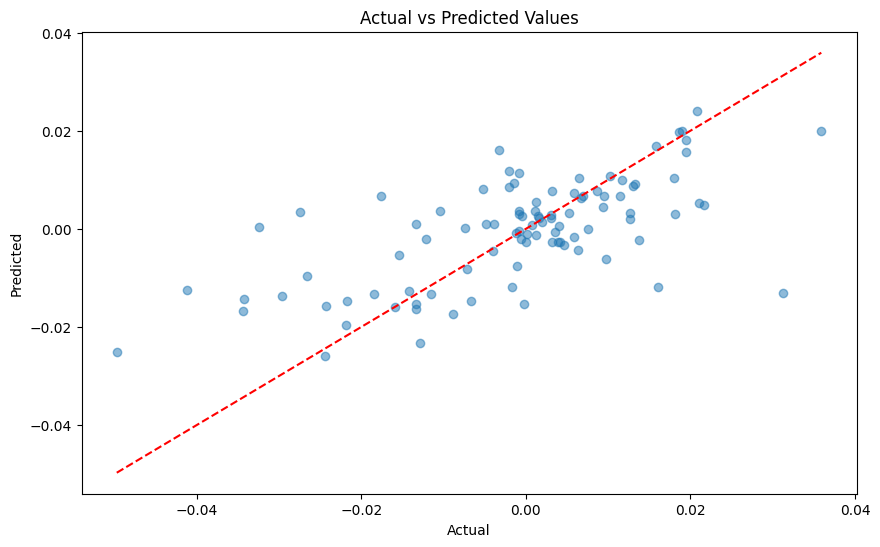

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
df.columns

Index(['Low', 'Close', 'Volume', 'Dividends', 'RSI_14', 'MACD', 'MACD_Signal',
       'ROC_10', 'S&P500_Return', 'S&P500_Correlation', 'Beta_S&P500',
       'Gold_Return', 'Gold_Correlation', 'Oil_Return', 'Oil_Correlation',
       'VIX_Return', 'VIX_Correlation', 'PE_Ratio', 'EPS', 'MA', 'BB_Width',
       'TR', 'Adaptive_ATR_Pct', 'log_returns', 'open_to_close',
       'daily_volatility', 'high_to_close', 'log_valuation', 'EMA_12_pct',
       'EMA_26_pct', 'Adaptive_BB_Middle_pct'],
      dtype='object')